<font color="red">注</font>: 使用 tensorboard 可视化需要安装 tensorflow (TensorBoard依赖于tensorflow库，可以任意安装tensorflow的gpu/cpu版本)

```shell
pip install tensorflow-cpu
```

In [35]:
!pwd

!ls -a
# # !cp kaggle.json ~/.kaggle/
# # !chmod 600 ~/.kaggle/kaggle.json
# !ls -l ~/.kaggle/
# !mkdir -p /mnt/workspace/cifar-10
# !ls -a
# !chmod 600 ~/.kaggle/kaggle.json 

/mnt/workspace
.   06_cifar10_model_1.ipynb  .ipynb_checkpoints  .virtual_documents
..  cifar-10		      .kaggle


In [2]:
pip install kaggle==1.5.3


Looking in indexes: https://mirrors.aliyun.com/pypi/simple/

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: /etc/dsw/runtime/python/bin/python3.9 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
!kaggle competitions download -c cifar-10

^C
User cancelled operation


In [ ]:
pip show kaggle

In [ ]:
!/etc/dsw/runtime/python/bin/kaggle competitions download -c cifar-10

In [31]:
pip install --upgrade kaggle

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.3
    Uninstalling kaggle-1.5.3:
      Successfully uninstalled kaggle-1.5.3

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: /etc/dsw/runtime/python/bin/python3.9 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [29]:
cat ~/.kaggle/kaggle.json

{"username":"xulangzhang123","key":"ced0c6a2a648061689c59d4aa3d4c58b"}

In [24]:
! ls /etc/dsw/runtime/python/bin/

2to3			  jupyter-execute		      pycodestyle
2to3-3.9		  jupyter-fileid		      pydoc3
autopep8		  jupyter-kernel		      pydoc3.9
chardetect		  jupyter-kernelspec		      pydocstyle
debugpy			  jupyter-lab			      pyfiglet
debugpy-adapter		  jupyter-labextension		      pyflakes
echo_supervisord_conf	  jupyter-labhub		      pyftmerge
f2py			  jupyter-migrate		      pyftsubset
flake8			  jupyter-nbclassic		      pygmentize
fonttools		  jupyter-nbclassic-bundlerextension  pygrun
get_gprof		  jupyter-nbclassic-extension	      pyjson5
get_objgraph		  jupyter-nbclassic-serverextension   pylint
get-port		  jupyter-nbconvert		      pylint-config
git-nbdiffdriver	  jupyter-nbextension		      pylsp
git-nbdifftool		  jupyter-notebook		      pyreverse
git-nbmergedriver	  jupyter-run			      python
git-nbmergetool		  jupyter-server		      python3
hg-nbdiff		  jupyter-serverextension	      python3.9
hg-nbdiffweb		  jupyter-troubleshoot		      python3.9-config
hg-nbmerge		  jupyter-trust			      python3

In [11]:
!apt update && apt install unzip -y

Hit:1 http://mirrors.cloud.aliyuncs.com/ubuntu jammy InRelease
Get:2 http://mirrors.cloud.aliyuncs.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://mirrors.cloud.aliyuncs.com/ubuntu jammy-backports InRelease [127 kB]0m
Get:4 http://mirrors.cloud.aliyuncs.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://mirrors.cloud.aliyuncs.com/ubuntu jammy-updates/universe Sources [582 kB]3m
Get:7 http://mirrors.cloud.aliyuncs.com/ubuntu jammy-updates/main Sources [697 kB]m
Get:6 https://developer.download.nvidia.cn/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:8 https://developer.download.nvidia.cn/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,853 kB]
Get:9 http://mirrors.cloud.aliyuncs.com/ubuntu jammy-updates/multiverse Sources [36.6 kB]
Get:10 http://mirrors.cloud.aliyuncs.com/ubuntu jammy-updates/restricted Sources [110 kB]
Get:11 http://mirrors.cloud.aliyuncs.com/ubuntu jammy-updates/universe amd64 Packages [1,575 kB]
Get:12 http://mirrors.cloud.aliyuncs.com

In [9]:
!ls -lh /mnt/workspace/cifar-10.zip

-rw-r--r-- 1 root root 716M  7月 30 22:56 /mnt/workspace/cifar-10.zip


In [13]:
!unzip -o -d /mnt/workspace/cifar-10 /mnt/workspace/cifar-10.zip >/dev/null

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
    
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42


sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)
matplotlib 3.7.5
numpy 1.26.4
pandas 2.2.3
sklearn 1.6.0
torch 2.7.1+cu126
cuda:0


## 数据准备

```shell
$ tree -L 1 cifar-10                                    
cifar-10
├── sampleSubmission.csv
├── test
├── train
└── trainLabels.csv
```

In [7]:
from pathlib import Path

DATA_DIR = Path("/mnt/workspace/cifar-10")

train_lables_file = DATA_DIR / "trainLabels.csv"
test_csv_file = DATA_DIR / "sampleSubmission.csv" #测试集模板csv文件
train_folder = DATA_DIR / "train"
test_folder = DATA_DIR / "test"

#所有的类别
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

def parse_csv_file(filepath, folder): #filepath:csv文件路径，folder:图片所在文件夹
    """Parses csv files into (filename(path), label) format"""
    results = []
    #读取所有行
    with open(filepath, 'r') as f:
#         lines = f.readlines()  为什么加[1:]，可以试这个
        #第一行不需要，因为第一行是标题
        lines = f.readlines()[1:] 
    for line in lines:#依次去取每一行
        image_id, label_str = line.strip('\n').split(',') #图片id 和标签分离
        image_full_path = folder / f"{image_id}.png"
        results.append((image_full_path, label_str)) #得到对应图片的路径和分类
    return results

#解析对应的文件夹
train_labels_info = parse_csv_file(train_lables_file, train_folder)
test_csv_info = parse_csv_file(test_csv_file, test_folder)
#打印
import pprint
pprint.pprint(train_labels_info[0:5])
pprint.pprint(test_csv_info[0:5])
print(len(train_labels_info), len(test_csv_info))

[(PosixPath('/mnt/workspace/cifar-10/train/1.png'), 'frog'),
 (PosixPath('/mnt/workspace/cifar-10/train/2.png'), 'truck'),
 (PosixPath('/mnt/workspace/cifar-10/train/3.png'), 'truck'),
 (PosixPath('/mnt/workspace/cifar-10/train/4.png'), 'deer'),
 (PosixPath('/mnt/workspace/cifar-10/train/5.png'), 'automobile')]
[(PosixPath('/mnt/workspace/cifar-10/test/1.png'), 'cat'),
 (PosixPath('/mnt/workspace/cifar-10/test/2.png'), 'cat'),
 (PosixPath('/mnt/workspace/cifar-10/test/3.png'), 'cat'),
 (PosixPath('/mnt/workspace/cifar-10/test/4.png'), 'cat'),
 (PosixPath('/mnt/workspace/cifar-10/test/5.png'), 'cat')]
50000 300000


In [8]:
# train_df = pd.DataFrame(train_labels_info)
train_df = pd.DataFrame(train_labels_info[0:45000]) # 取前45000张图片作为训练集
valid_df = pd.DataFrame(train_labels_info[45000:]) # 取后5000张图片作为验证集
test_df = pd.DataFrame(test_csv_info)

train_df.columns = ['filepath', 'class']
valid_df.columns = ['filepath', 'class']
test_df.columns = ['filepath', 'class']

print(train_df.head())
print(valid_df.head())
print(test_df.head())

                              filepath       class
0  /mnt/workspace/cifar-10/train/1.png        frog
1  /mnt/workspace/cifar-10/train/2.png       truck
2  /mnt/workspace/cifar-10/train/3.png       truck
3  /mnt/workspace/cifar-10/train/4.png        deer
4  /mnt/workspace/cifar-10/train/5.png  automobile
                                  filepath       class
0  /mnt/workspace/cifar-10/train/45001.png       horse
1  /mnt/workspace/cifar-10/train/45002.png  automobile
2  /mnt/workspace/cifar-10/train/45003.png        deer
3  /mnt/workspace/cifar-10/train/45004.png  automobile
4  /mnt/workspace/cifar-10/train/45005.png    airplane
                             filepath class
0  /mnt/workspace/cifar-10/test/1.png   cat
1  /mnt/workspace/cifar-10/test/2.png   cat
2  /mnt/workspace/cifar-10/test/3.png   cat
3  /mnt/workspace/cifar-10/test/4.png   cat
4  /mnt/workspace/cifar-10/test/5.png   cat


In [ ]:
!pip install torchvision

In [12]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class Cifar10Dataset(Dataset):
    df_map = {
        "train": train_df,
        "eval": valid_df,
        "test": test_df
    }
    label_to_idx = {label: idx for idx, label in enumerate(class_names)} # 类别映射为idx
    idx_to_label = {idx: label for idx, label in enumerate(class_names)} # idx映射为类别,为了test使用
    def __init__(self, mode, transform=None):
        self.df = self.df_map.get(mode, None) # 获取对应模式的df，不同字符串对应不同模式
        if self.df is None:
            raise ValueError("mode should be one of train, val, test, but got {}".format(mode))
        # assert self.df, "df is None"
        self.transform = transform
        
    def __getitem__(self, index):
        img_path, label = self.df.iloc[index] # 获取图片路径和标签
        img = Image.open(img_path).convert('RGB')
        # # img 转换为 channel first
        # img = img.transpose((2, 0, 1))
        # transform
        img = self.transform(img) # 数据增强
        # label 转换为 idx
        label = self.label_to_idx[label]
        return img, label
    
    def __len__(self):
        return self.df.shape[0] # 返回df的行数,样本数
    
IMAGE_SIZE = 32
mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]

transforms_train = transforms.Compose([
        # resize
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), #缩放
        # random rotation 40
        transforms.RandomRotation(40), #随机旋转
        # horizaontal flip
        transforms.RandomHorizontalFlip(),  #随机水平翻转
        transforms.ToTensor(), #转换为tensor
        transforms.Normalize(mean, std) #标准化
    ]) #数据增强

transforms_eval = transforms.Compose([
        # resize
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
# ToTensor还将图像的维度从[height, width, channels]转换为[channels, height, width]。
train_ds = Cifar10Dataset("train", transforms_train)
eval_ds = Cifar10Dataset("eval", transforms_eval)

In [10]:
!ls /mnt/workspace
%pwd
!find /mnt/workspace -type d -name "__pycache__" -exec rm -r {} +
!find /mnt/workspace -type f -name "*.pyc" -delete

04_10_monkeys_model_1_aliyun.ipynb  06_cifar10_model_1.ipynb  cifar-10.zip
04_10_monkeys_model_1.ipynb	    cifar-10		      kaggle.json


In [14]:
!apt update && apt install -y p7zip-full

Hit:1 http://mirrors.cloud.aliyuncs.com/ubuntu jammy InRelease
Get:2 http://mirrors.cloud.aliyuncs.com/ubuntu jammy-updates InRelease [128 kB]
Hit:3 http://mirrors.cloud.aliyuncs.com/ubuntu jammy-backports InRelease       
Get:4 http://mirrors.cloud.aliyuncs.com/ubuntu jammy-security InRelease [129 kB]m
Get:5 http://mirrors.cloud.aliyuncs.com/ubuntu jammy-updates/main Sources [697 kB]3m
Get:7 http://mirrors.cloud.aliyuncs.com/ubuntu jammy-updates/universe amd64 Packages [1,575 kB]
Hit:6 https://developer.download.nvidia.cn/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:8 http://mirrors.cloud.aliyuncs.com/ubuntu jammy-updates/main amd64 Packages [3,516 kB]
Fetched 6,045 kB in 1s (8,399 kB/s)                    
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
59 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The followi

In [47]:
# 解压 test.7z 到 /mnt/workspace/cifar-10/
!7z x /mnt/workspace/cifar-10/test.7z -o/mnt/workspace/cifar-10/
# !7z x /mnt/workspace/cifar-10/train.7z -o/mnt/workspace/cifar-10/
print("✅ 解压完成！")

^C
(Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? ✅ 解压完成！


In [20]:
train_ds[0][0].shape # 图片的shape,输入

torch.Size([3, 32, 32])

In [21]:
print(train_ds.idx_to_label)  # 类别映射为idx
train_ds.label_to_idx # idx映射为类别

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [23]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)   
eval_dl = DataLoader(eval_ds, batch_size=batch_size, shuffle=False)

In [25]:
# 遍历train_ds得到每张图片，计算每个通道的均值和方差
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds:
        mean += img.mean(dim=(1, 2))
        std += img.std(dim=(1, 2))
    mean /= len(ds)
    std /= len(ds)
    return mean, std

# 经过 normalize 后 均值为0，方差为1
# print(cal_mean_std(train_ds))

## 定义模型

In [26]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(128),# 批标准化，在批次上做归一化
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding="same"), #输出尺寸（128，32，32）
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2), #输出尺寸（128，16，16）
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding="same"), #输出尺寸（256，16，16）
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2),#输出尺寸（256，8，8）
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding="same"), #输出尺寸（512，8，8）
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2), #输出尺寸（512，4，4）
            nn.Flatten(), #展平
            nn.Linear(8192, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        ) #Sequential自动连接各层，把各层的输出作为下一层的输入
        
    def forward(self, x):
        return self.model(x)
        
for key, value in CNN(len(class_names)).named_parameters():
    print(f"{key:^40}paramerters num: {np.prod(value.shape)}")
    


             model.0.weight             paramerters num: 3456
              model.0.bias              paramerters num: 128
             model.2.weight             paramerters num: 128
              model.2.bias              paramerters num: 128
             model.3.weight             paramerters num: 147456
              model.3.bias              paramerters num: 128
             model.5.weight             paramerters num: 128
              model.5.bias              paramerters num: 128
             model.7.weight             paramerters num: 294912
              model.7.bias              paramerters num: 256
             model.9.weight             paramerters num: 256
              model.9.bias              paramerters num: 256
            model.10.weight             paramerters num: 589824
             model.10.bias              paramerters num: 256
            model.12.weight             paramerters num: 256
             model.12.bias              paramerters num: 256
            mo

In [27]:
total_params = sum(p.numel() for p in CNN(len(class_names)).parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 8779914


In [28]:
512*4*4

8192

## 训练

pytorch的训练需要自行实现，包括
1. 定义损失函数
2. 定义优化器
3. 定义训练步
4. 训练

In [29]:
from sklearn.metrics import accuracy_score

@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)         # 验证集损失
        loss_list.append(loss.item())
        
        preds = logits.argmax(axis=-1)    # 验证集预测
        pred_list.extend(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())
        
    acc = accuracy_score(label_list, pred_list)
    return np.mean(loss_list), acc


### TensorBoard 可视化


训练过程中可以使用如下命令启动tensorboard服务。

```shell
tensorboard \
    --logdir=runs \     # log 存放路径
    --host 0.0.0.0 \    # ip
    --port 8848         # 端口
```

In [30]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))
        
    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss", 
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
            )
        
    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )
        
    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,
            
        )
    
    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)


### Save Best


In [32]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1
        
        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)
        
    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return
        
        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))



### Early Stop

In [33]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0
        
    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else: 
            self.counter += 1
            
    @property
    def early_stop(self):
        return self.counter >= self.patience


In [62]:
# 训练
def training(
    model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    tensorboard_callback=None,
    save_ckpt_callback=None,
    early_stop_callback=None,
    eval_step=500,
    ):
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits.argmax(axis=-1) #最大值的索引
            
                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())     # 计算准确率
                loss = loss.cpu().item() # 计算损失
                # record
                
                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step # 记录每一步的损失和准确率
                })
                
                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()
                    
                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step, 
                            loss=loss, val_loss=val_loss,
                            acc=acc, val_acc=val_acc,
                            lr=optimizer.param_groups[0]["lr"],
                            )
                
                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                    
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict
        

epoch = 20

model = CNN(num_classes=10)

# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.CrossEntropyLoss()
# 2. 定义优化器 采用 adam
# Optimizers specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 1. tensorboard 可视化
if not os.path.exists("runs"):
    os.mkdir("runs")
tensorboard_callback = TensorBoardCallback("runs/cifar-10")
tensorboard_callback.draw_model(model, [1, 3, IMAGE_SIZE, IMAGE_SIZE])
# 2. save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback("checkpoints/cifar-10", save_step=len(train_dl), save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=5)

model = model.to(device)


In [ ]:
record = training(
    model,
    train_dl,
    eval_dl,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=tensorboard_callback,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=len(train_dl)
    )

  0%|          | 0/14080 [00:00<?, ?it/s]

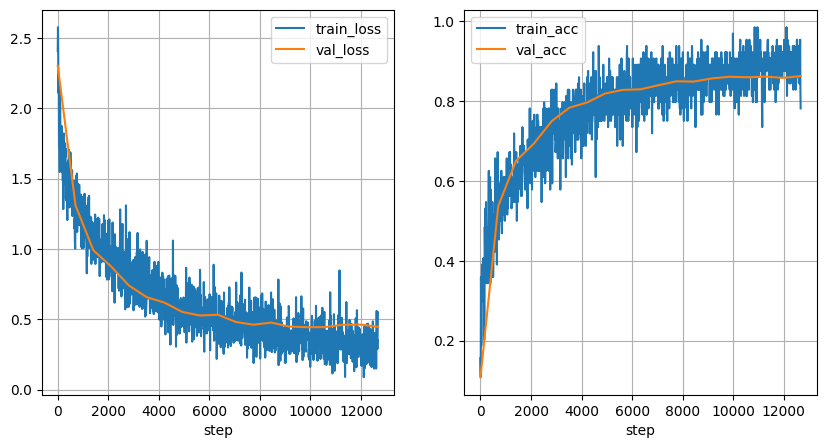

In [36]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):    
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        # axs[idx].set_xticks(range(0, train_df.index[-1], 5000))
        # axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, train_df.index[-1], 5000)))
        axs[idx].set_xlabel("step")
    
    plt.show()

plot_learning_curves(record, sample_step=10)  #横坐标是 steps

# 评估

In [37]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(torch.load("checkpoints/cifar-10/best.ckpt", map_location="cpu"))

model.eval()
loss, acc = evaluating(model, eval_dl, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

loss:     0.4466
accuracy: 0.8620


# 推理

In [48]:
# test_df
test_ds = Cifar10Dataset("test", transform=transforms_eval)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=False)

preds_collect = [] # 预测结果收集器
model.eval()
for data, fake_label in tqdm(test_dl):
    data = data.to(device=device)
    logits = model(data) #得到预测结果
    preds = [test_ds.idx_to_label[idx] for idx in logits.argmax(axis=-1).cpu().tolist()] # 得到预测类别，idx_to_label是id到字符串类别的映射
    preds_collect.extend(preds)
    
test_df["label"] = preds_collect # 增加预测类别列,比赛要求这一列是label
test_df.head()

  0%|          | 0/4688 [00:00<?, ?it/s]

,filepath,class,label
0,/mnt/workspace/cifar-10/test/1.png,cat,truck
1,/mnt/workspace/cifar-10/test/2.png,cat,airplane
2,/mnt/workspace/cifar-10/test/3.png,cat,automobile
3,/mnt/workspace/cifar-10/test/4.png,cat,ship
4,/mnt/workspace/cifar-10/test/5.png,cat,airplane


In [53]:
test_df.head()

,filepath,class,label
0,/mnt/workspace/cifar-10/test/1.png,cat,truck
1,/mnt/workspace/cifar-10/test/2.png,cat,airplane
2,/mnt/workspace/cifar-10/test/3.png,cat,automobile
3,/mnt/workspace/cifar-10/test/4.png,cat,ship
4,/mnt/workspace/cifar-10/test/5.png,cat,airplane


In [54]:
test_df1 = pd.DataFrame(list(range(1,3*10**5+1)), columns=["id"])
test_df1

,id
0,1
1,2
2,3
3,4
4,5
...,...
299995,299996
299996,299997
299997,299998
299998,299999


In [56]:
test_df1["label"] = preds_collect # 增加预测类别列,比赛要求这一列是label
test_df1.head()

,id,label
0,1,truck
1,2,airplane
2,3,automobile
3,4,ship
4,5,airplane


In [61]:
# 导出 submission.csv
test_df1.to_csv("submission.csv", index=False)